In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
# Cargar el dataset limpio
file_path_hogar = '../../../../data/processed/datos_consumo/hogar_individual_bcn/casa_bcn_clean.csv'
df = pd.read_csv(file_path_hogar)
df

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,timestamp,consumo_kwh,tmed,tmin,tmax,prec,velmedia,racha,sol,hrMedia,año
0,2017-12-11 01:00:00,0.327,10.3,7.2,13.4,1.6,5.0,21.7,0.7,74.0,2017
1,2017-12-11 02:00:00,0.180,10.3,7.2,13.4,1.6,5.0,21.7,0.7,74.0,2017
2,2017-12-11 03:00:00,0.138,10.3,7.2,13.4,1.6,5.0,21.7,0.7,74.0,2017
3,2017-12-11 04:00:00,0.137,10.3,7.2,13.4,1.6,5.0,21.7,0.7,74.0,2017
4,2017-12-11 05:00:00,0.135,10.3,7.2,13.4,1.6,5.0,21.7,0.7,74.0,2017
...,...,...,...,...,...,...,...,...,...,...,...
19459,2020-02-29 20:00:00,0.154,14.0,9.6,18.5,0.0,3.6,10.3,4.8,74.0,2020
19460,2020-02-29 21:00:00,0.115,14.0,9.6,18.5,0.0,3.6,10.3,4.8,74.0,2020
19461,2020-02-29 22:00:00,0.115,14.0,9.6,18.5,0.0,3.6,10.3,4.8,74.0,2020
19462,2020-02-29 23:00:00,0.109,14.0,9.6,18.5,0.0,3.6,10.3,4.8,74.0,2020


In [2]:

# Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Renombrar columnas para Prophet
df_prophet = df[['timestamp', 'consumo_kwh']].rename(columns={'timestamp': 'ds', 'consumo_kwh': 'y'})

# Separar entrenamiento (hasta 2019) y validación (2020)
train = df_prophet[df_prophet['ds'] < '2020-01-01']
test = df_prophet[df_prophet['ds'] >= '2020-01-01']

# Definir los festivos de Barcelona
festivos = pd.DataFrame({
    'holiday': 'festivo',
    'ds': pd.to_datetime([
        # 2017
        "2017-01-06", "2017-04-14", "2017-04-17", "2017-05-01", "2017-06-05", 
        "2017-06-24", "2017-08-15", "2017-09-11", "2017-09-25", "2017-10-12",
        "2017-11-01", "2017-12-06", "2017-12-08", "2017-12-25", "2017-12-26",
        # 2018
        "2018-01-01", "2018-01-06", "2018-03-30", "2018-04-02", "2018-05-01",
        "2018-08-15", "2018-09-11", "2018-10-12", "2018-11-01", "2018-12-06",
        "2018-12-08", "2018-12-25", "2018-12-26",
        # 2019
        "2019-01-01", "2019-04-19", "2019-04-22", "2019-05-01", "2019-06-10",
        "2019-06-24", "2019-08-15", "2019-09-11", "2019-09-24", "2019-10-12",
        "2019-11-01", "2019-12-06", "2019-12-25", "2019-12-26",
        # 2020
        "2020-01-01", "2020-01-06", "2020-04-10", "2020-04-13", "2020-05-01",
        "2020-06-01", "2020-06-24", "2020-08-15", "2020-09-11", "2020-09-24",
        "2020-10-12", "2020-12-08", "2020-12-25", "2020-12-26"
    ]),
    'lower_window': 0,
    'upper_window': 1
})

In [3]:
# Crear y configurar el modelo Prophet
modelo = Prophet(
    changepoint_prior_scale=0.5,  # Permite adaptarse mejor a cambios bruscos
    seasonality_mode='multiplicative',
    holidays=festivos
)

# Añadir estacionalidades personalizadas
modelo.add_seasonality(name='trimestral', period=90.25, fourier_order=10)  # Trimestral
modelo.add_seasonality(name='mensual', period=30.5, fourier_order=10)  # Mensual
modelo.add_seasonality(name='semanal', period=7, fourier_order=10)  # Semanal

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(train)

21:57:13 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
# Crear un dataframe de predicción para 1 año más
future = modelo.make_future_dataframe(periods=24 * 365, freq='H')

# Hacer predicciones
forecast = modelo.predict(future)

In [5]:

# Inicializar variables para predicciones ajustadas
rmse_values = []
mae_values = []
predicciones_totales = pd.DataFrame()
errores_previos = []

# Validación secuencial sin reentrenar
for dia in pd.date_range(start='2020-01-01', end=test['ds'].max(), freq='D'):
    # Filtrar datos reales del día a predecir
    test_dia = test[(test['ds'] >= dia) & (test['ds'] < dia + pd.Timedelta(days=1))]
    
    if test_dia.empty:
        continue  # Saltar si no hay datos para este día
    
    # Crear dataframe para predecir solo ese día
    future = pd.DataFrame({'ds': test_dia['ds']})
    
    # Hacer la predicción
    forecast = modelo.predict(future)
    
    # Calcular error residual promedio de los últimos días
    if len(errores_previos) > 10:  # Usar los últimos 10 días
        ajuste_error = np.mean(errores_previos[-10:])
    else:
        ajuste_error = 0  # No ajustar si no hay suficientes datos previos

    # Aplicar ajuste a la predicción
    forecast['yhat_ajustado'] = forecast['yhat'] + ajuste_error
    
    # Calcular métricas de error
    rmse = np.sqrt(mean_squared_error(test_dia['y'], forecast['yhat_ajustado']))
    mae = mean_absolute_error(test_dia['y'], forecast['yhat_ajustado'])
    
    rmse_values.append(rmse)
    mae_values.append(mae)
    
    # Guardar errores para ajuste futuro
    errores_previos.extend(test_dia['y'].values - forecast['yhat'].values)
    
    # Guardar predicciones
    forecast['real'] = test_dia['y'].values
    predicciones_totales = pd.concat([predicciones_totales, forecast[['ds', 'yhat', 'yhat_ajustado', 'real']]])

In [6]:

# Calcular métricas finales
rmse_final = np.mean(rmse_values)
mae_final = np.mean(mae_values)

print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")


RMSE Final: 0.30
MAE Final: 0.23


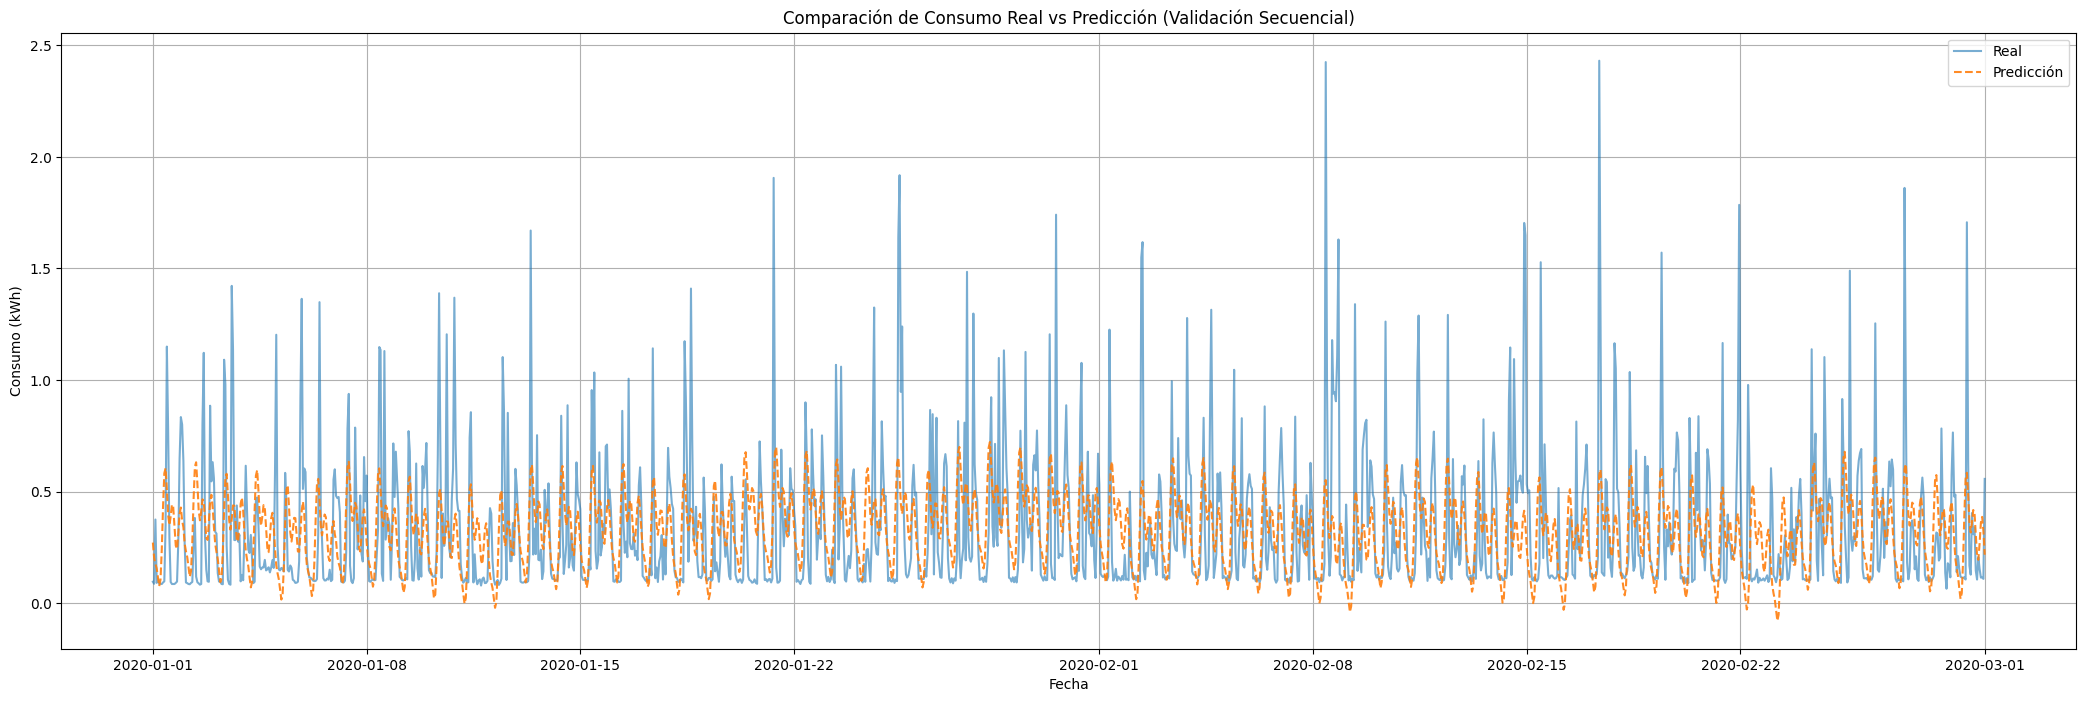

In [7]:
# Graficar los valores reales vs predichos
plt.figure(figsize=(26, 8))
plt.plot(predicciones_totales['ds'], predicciones_totales['real'], label="Real", alpha=0.6)
plt.plot(predicciones_totales['ds'], predicciones_totales['yhat'], label="Predicción", alpha=0.9, linestyle="dashed")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.title("Comparación de Consumo Real vs Predicción (Validación Secuencial)")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Guardar el gráfico
plot_path = "prophet_predictions.png"
plt.savefig(plot_path)
plt.show()

<Figure size 640x480 with 0 Axes>

In [9]:
import dagshub
import mlflow
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='Proyectos-SGBA1', mlflow=True)

Accessing as anaigs

Initialized MLflow to track repo "auditoria.SGBA1/Proyectos-SGBA1"

Repository auditoria.SGBA1/Proyectos-SGBA1 initialized!

In [12]:
# Clase personalizada para Prophet en MLflow
class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        model_input = pd.DataFrame(model_input)
        model_input.columns = ['ds']
        forecast = self.model.predict(model_input)
        return forecast[['ds', 'yhat']]

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\pyfunc\utils\data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [18]:
# Registrar modelo en MLflow
with mlflow.start_run(run_name="prophet_consumo_individual_basico") as run:
    run_id = run.info.run_id
    model_name = "Prophet-Consumo-Hogar"
    model_uri = f"runs:/{run_id}/prophet_model"

    # Registrar hiperparámetros de Prophet
    mlflow.log_param("changepoint_prior_scale", 0.5)
    mlflow.log_param("seasonality_mode", "multiplicative")
    mlflow.log_param("trimestral_period", 90.25)
    mlflow.log_param("mensual_period", 30.5)
    mlflow.log_param("semanal_period", 7)
    mlflow.log_param("trimestral_fourier_order", 10)
    mlflow.log_param("mensual_fourier_order", 10)
    mlflow.log_param("semanal_fourier_order", 10)

    # Registrar métricas
    mlflow.log_metric("RMSE", rmse_final)
    mlflow.log_metric("MAE", mae_final)
    mlflow.log_artifact(plot_path)

    # Registrar modelo en MLflow
    mlflow.pyfunc.log_model(artifact_path="prophet_model", python_model=ProphetWrapper(modelo))

    mlflow.register_model(model_uri=model_uri, name=model_name)

2025/03/13 22:07:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Prophet-Consumo-Hogar'.
2025/03/13 22:07:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Prophet-Consumo-Hogar, version 1
Created version '1' of model 'Prophet-Consumo-Hogar'.


🏃 View run prophet_consumo_individual_basico at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0/runs/8e1b07d7eb334b97af2011a5c704b8ba
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0
